In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Conv1D, Dense, BatchNormalization, Activation, GlobalAveragePooling1D, Dropout, Normalization

In [2]:
seed_value = 123
tf.random.set_seed(seed_value)
np.random.seed(seed_value)

In [3]:
basedir = r"C:\Users\tmhnguyen\Documents\lalamove\lalamove\data\Clean_extracted_240115_uncal\train"
labels = [5, 6, 7]
synthetic_percent = {5: 0.5, 6: 0.1, 7: 0.5}
with open(basedir + '/../data_split_params.json', 'r') as file:
    features = json.load(file)['FEATURES']
print(features)

{'5': ['z_gyro_clean', 'y_gyro_clean', 'x_gyro_clean', 'x_acc_clean', 'y_acc_clean', 'z_acc_clean', 'acceleration', 'speed_kmh'], '6': ['z_gyro_clean', 'y_gyro_clean', 'x_gyro_clean', 'x_acc_clean', 'y_acc_clean', 'z_acc_clean', 'acceleration', 'speed_kmh'], '7': ['z_gyro_clean', 'y_gyro_clean', 'x_gyro_clean', 'x_acc_clean', 'y_acc_clean', 'z_acc_clean', 'acceleration', 'speed_kmh']}


In [4]:
label = 7

In [5]:
y_ori = pd.read_csv(basedir + f'/{label}/train_label_{label}.csv')
X_ori = []
step = 30_000
for i in range(np.ceil(len(y_ori)/30_000).astype(int)):
    temp = pd.read_csv(basedir + f'/{label}/extract_features_{label}_{i}.csv', index_col=0)
    X_ori.append(temp)
X_ori = pd.concat(X_ori)
assert len(X_ori) == len(y_ori), f"Length mismatch {len(X_ori)}, {len(y_ori)}"

In [6]:
def create_model(xtrain, input_shape=500):
    inputs = Input(shape=input_shape)
    scaler = Normalization()
    scaler.adapt(xtrain)
    scaled_inputs = scaler(inputs)
    x = Dense(500, activation='relu')(scaled_inputs)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(50, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=output)
    return model

In [7]:
dates = y_ori.date.unique()
test_date = 20231227
val_date = 20231228

test_idx = y_ori[(y_ori.date == test_date) & (y_ori.type == 0)].index
X_test = X_ori.iloc[test_idx]
y_test = y_ori.iloc[test_idx].reset_index().label

y = y_ori[y_ori.date != test_date].reset_index()
X = X_ori.iloc[y.index]

val_idx = y[(y.date == val_date) & (y.type == 0)].index
train_idx = y[(y.date != val_date) & (y.type == 0)]
train_idx_add = y[(y.date != val_date) & (y.type == 1)].sample(frac=synthetic_percent[label])
train_idx = pd.concat([train_idx, train_idx_add]).index

# Split the data into training and validation sets
X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
y_train, y_val = y.iloc[train_idx].reset_index().label, y.iloc[val_idx].reset_index().label

print('test date is ', test_date)
print('ori data shapes: ', X_ori.shape, y_ori.shape, X.shape, y.shape)
print('val date is ', val_date)
print('split data shapes: ', X_test.shape, X_train.shape, X_val.shape)

test date is  20231227
ori data shapes:  (381067, 500) (381067, 6) (353861, 500) (353861, 7)
val date is  20231228
split data shapes:  (20966, 500) (276132, 500) (13649, 500)


In [8]:
models = []  # List to store weak classifiers
alphas = []  # List to store model weights
n_models = 10  # Number of weak classifiers to train
rand_states = np.random.randint(1, 10000, size=n_models)  # Generate random states for each classifier
sample_weights = np.ones(len(X_train))  # Initialize sample weights
sample_weights[y_train == 1] *= 5
sample_weights = sample_weights / sample_weights.sum()

# Iterate over each date in the list of dates, excluding the test_date
for i in range(n_models):
    print(f'{i+1}th weak classifier in the ensemble')  # Print the current classifier number and date
    
    tf.keras.backend.clear_session()  # Release resources associated with the previous classifier

    # use the sample weights to create training set
    print('  generate training samples')
    indices = np.random.choice(range(len(X_train)), size=len(X_train), p=sample_weights, replace=True)
    X_train_en = X_train.iloc[indices]
    y_train_en = y_train.iloc[indices]
    
    # Create and train the weak classifier
    print('  train weak learners')
    model = create_model(X_train_en, input_shape=X_train_en.shape[1])
    model.compile(optimizer=Adam(learning_rate=1e-5),
                  loss='binary_crossentropy',
                  metrics=[BinaryAccuracy(name='acc'),
                           Precision(name='precision'),
                           Recall(name='recall')])
    
    history = model.fit(X_train_en, y_train_en, batch_size=256, epochs=30, validation_data=(X_val, y_val),
                        callbacks=[EarlyStopping(patience=20, min_delta=0.0005, restore_best_weights=True)],
                        verbose=True)
    
    # Compute the weighted error of the weak classifier
    predictions = (model.predict(X_train_en) >= 0.5).flatten().astype(int)
    weighted_error = np.sum(sample_weights[indices] * (predictions != y_train_en)) / np.sum(sample_weights[indices])
    
    # Compute the model weight of the weak classifier
    alpha = 0.5 * np.log((1 - weighted_error) / weighted_error)
    
    # Update the sample weights based on the weak classifier's performance
    sample_weights[indices] *= np.exp(alpha * (predictions != y_train_en))
    sample_weights /= np.sum(sample_weights)
    
    models.append(model)  # Add the weak classifier and its weight to the list of models
    alphas.append(alpha)

# normalized model weights
alphas = np.array(alphas)
alphas = alphas / alphas.sum()

# AdaBoost prediction
predictions = np.zeros(len(X_test))
for model, alpha in zip(models, alphas):
    predictions += alpha * model.predict(X_test).flatten()
    
predictions = (predictions >= 0.5).astype(int)

# Evaluate the AdaBoost ensemble on the test set
accuracy = np.mean(predictions == y_test)
print("Accuracy on test set:", accuracy)

1th weak classifier in the ensemble
  generate training samples
  train weak learners
Epoch 1/30
1079/1079 [==============================] - 5s 4ms/step - loss: 0.4996 - acc: 0.7334 - precision: 0.8550 - recall: 0.6239 - val_loss: 0.3693 - val_acc: 0.8642 - val_precision: 0.0917 - val_recall: 0.3833
Epoch 2/30
1079/1079 [==============================] - 4s 4ms/step - loss: 0.2406 - acc: 0.9234 - precision: 0.9281 - recall: 0.9338 - val_loss: 0.3915 - val_acc: 0.8867 - val_precision: 0.1139 - val_recall: 0.3952
Epoch 3/30
1079/1079 [==============================] - 4s 3ms/step - loss: 0.1920 - acc: 0.9428 - precision: 0.9538 - recall: 0.9422 - val_loss: 0.4241 - val_acc: 0.8864 - val_precision: 0.1135 - val_recall: 0.3952
Epoch 4/30
1079/1079 [==============================] - 4s 3ms/step - loss: 0.1745 - acc: 0.9488 - precision: 0.9622 - recall: 0.9446 - val_loss: 0.4474 - val_acc: 0.8850 - val_precision: 0.1121 - val_recall: 0.3952
Epoch 5/30
1079/1079 [============================

In [9]:
def ensemble_predict(models, xtest):
    predictions = np.zeros(len(X_test))
    for model, alpha in zip(models, alphas):
        predictions += alpha * model.predict(X_test).flatten()
        
    return predictions

656/656 [==============================] - 1s 1ms/step


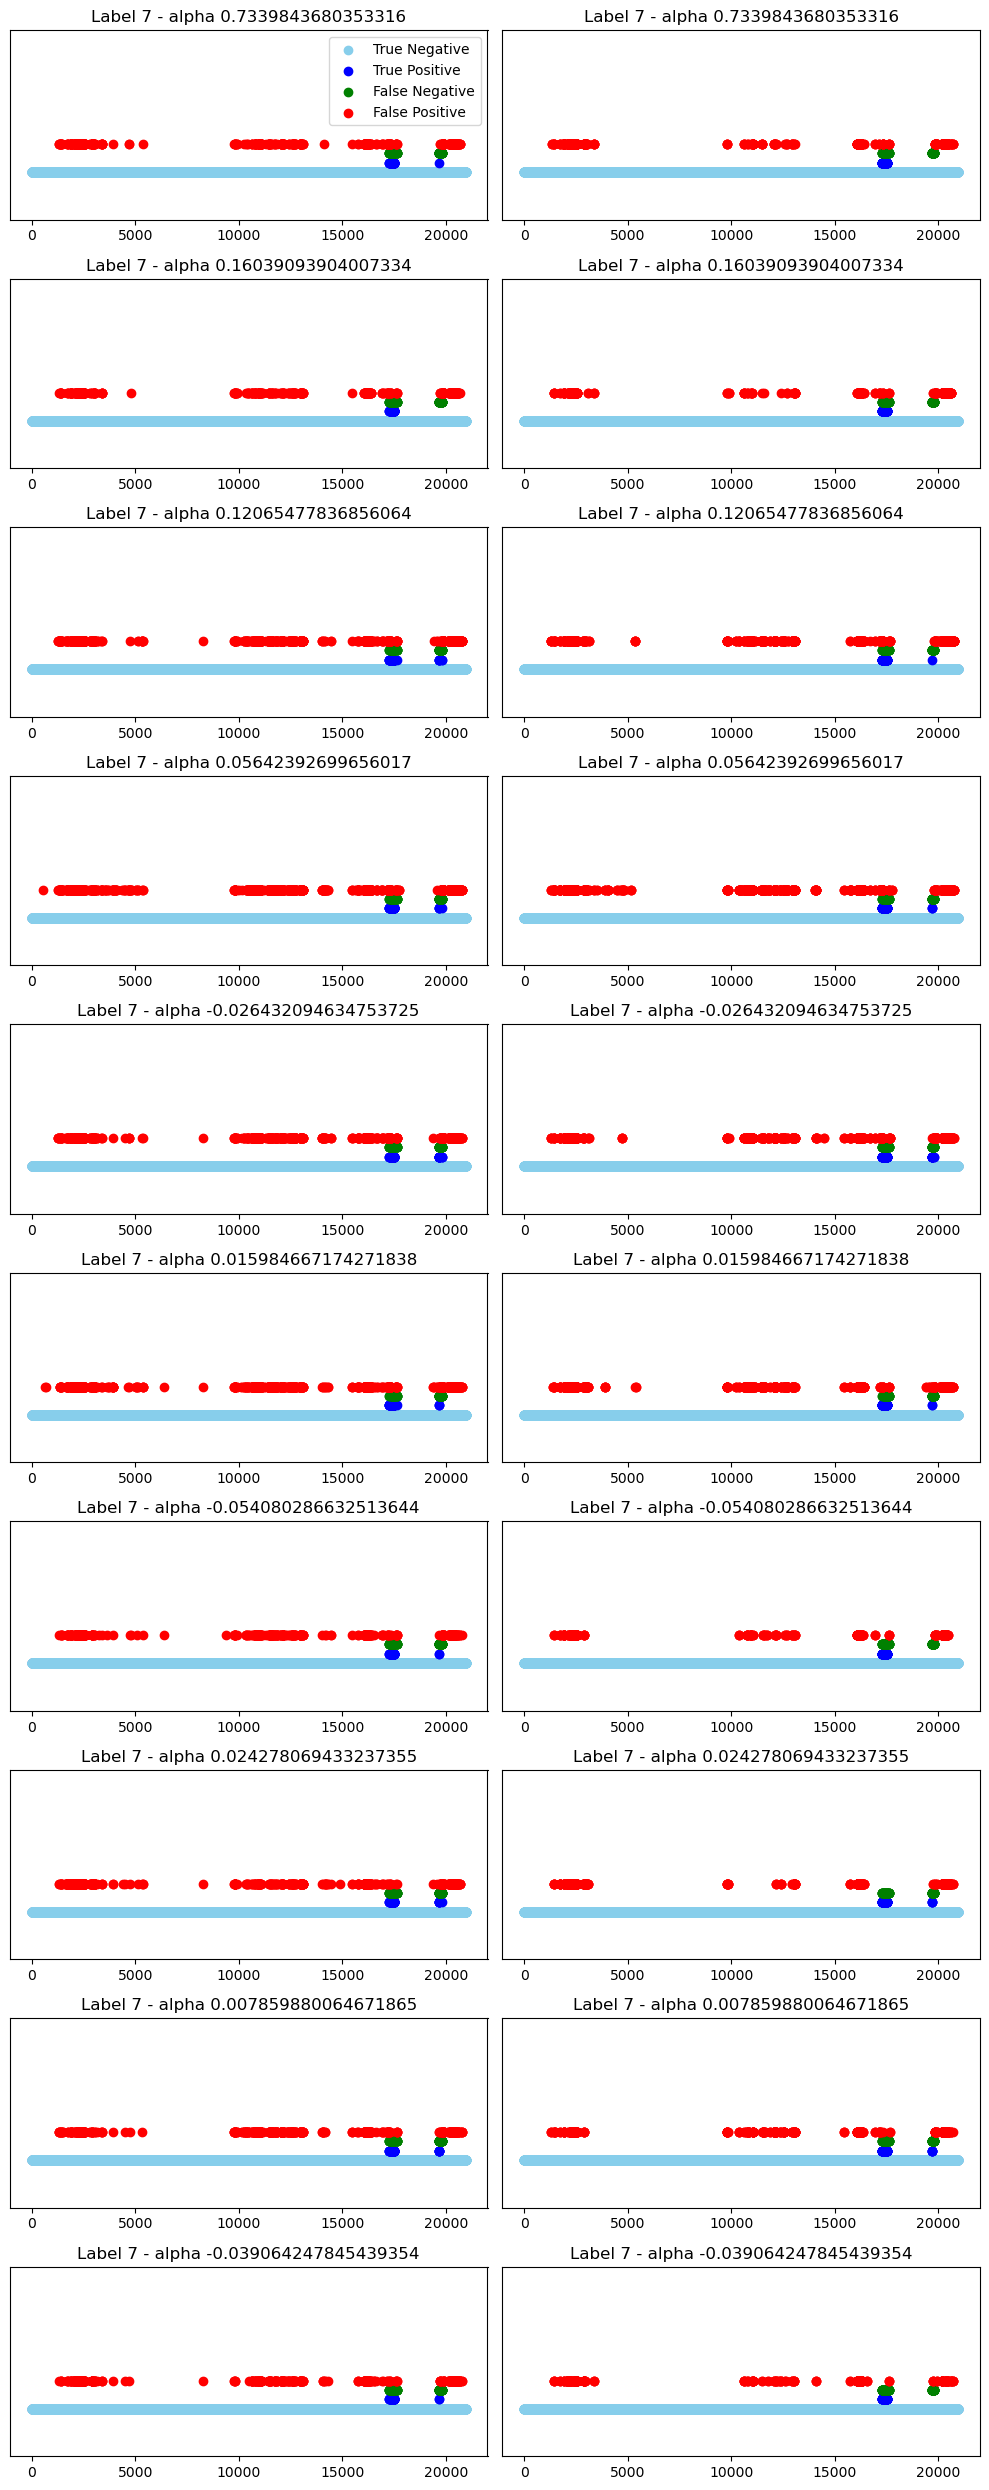

In [10]:
def classify(row, col='pred'):
    true, pred = row.true, row[col]
    if true == pred and true == 0:
        return 'True Negative'
    elif true == pred and true == 1:
        return 'True Positive'
    elif true != pred and true == 0:
        return 'False Positive'
    else:
        return 'False Negative'


fig, axes = plt.subplots(nrows=len(models), ncols=2, figsize=(10, 25))
for k, model in enumerate(models):    
    pred = model.predict(X_test) >= 0.5
    df = pd.DataFrame(np.hstack((y_test.to_numpy().reshape(-1, 1), pred)), columns=['true', 'pred'])
    df.pred = df.pred.astype(int)        
    df['type'] = df.apply(lambda x: classify(x), axis=1)
    types = df.type.value_counts().sort_index()[::-1]

    w = 5 # window in seconds
    pred_avg = np.convolve(pred.flatten(), np.ones(w), mode='same') / w >= 0.5
    df['pred_avg'] = pred_avg
    df.pred_avg = df.pred_avg.astype(int)        
    df['type_avg'] = df.apply(lambda x: classify(x, col='pred_avg'), axis=1)
    types_avg = df.type_avg.value_counts().sort_index()[::-1]

    colors = ['skyblue', 'blue', 'green', 'red']
    types_ = ['True Negative', 'True Positive', 'False Negative', 'False Positive']

    i = 0.5
    for j, t in enumerate(types_):
        try:
            axes[k, 0].scatter(df[df.type==t].index, [i]*types[t], label=t, c=colors[j])
        except KeyError:
            pass
        i += 0.1

    axes[k, 0].set_ylim(0, 2)
    axes[k, 0].get_yaxis().set_visible(False)
    axes[k, 0].set_title(f'Label {label} - alpha {alphas[k]}')

    i = 0.5
    for j, t in enumerate(types_):
        try:
            axes[k, 1].scatter(df[df.type_avg==t].index, [i]*types_avg[t], label=t, c=colors[j])
        except KeyError:
            pass
        i += 0.1

    axes[k, 1].set_ylim(0, 2)
    axes[k, 1].get_yaxis().set_visible(False)
    axes[k, 1].set_title(f'Label {label} - alpha {alphas[k]}')  

axes[0, 0].legend()
plt.tight_layout()

656/656 [==============================] - 1s 1ms/step
(20966,) (20966,)
type
True Positive        93
True Negative     20127
False Positive      630
False Negative      116
Name: count, dtype: int64


Text(0.5, 1.0, '7 NO average smoothing')

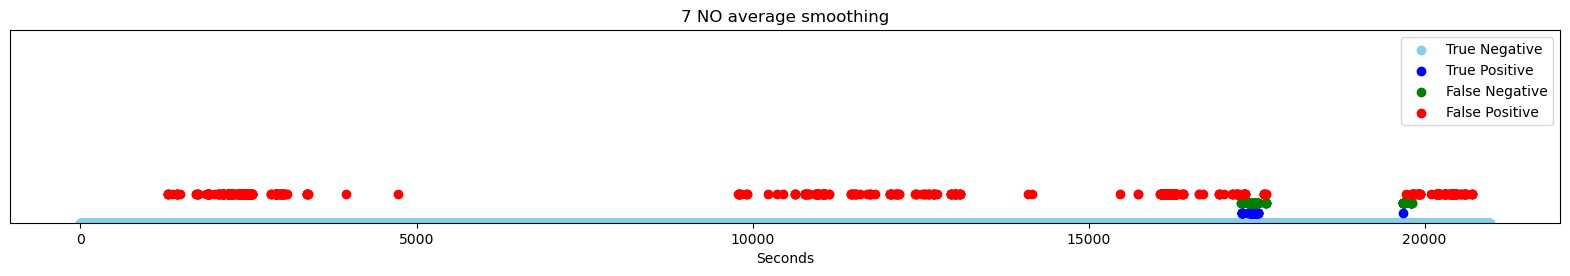

In [11]:
pred = ensemble_predict(models, X_test) >= 0.5
print(pred.shape, y_test.shape)

df = pd.DataFrame(np.vstack((y_test.to_numpy(), pred)).T, columns=['true', 'pred'])
df.pred = df.pred.astype(int)

def classify(row):
    true, pred = row.true, row.pred
    if true == pred and true == 0:
        return 'True Negative'
    elif true == pred and true == 1:
        return 'True Positive'
    elif true != pred and true == 0:
        return 'False Positive'
    else:
        return 'False Negative'
    
df['type'] = df.apply(lambda x: classify(x), axis=1)
types = df.type.value_counts().sort_index()[::-1]
print(types)

fig, ax = plt.subplots(figsize=(20, 2.5))
i = 0
colors = ['skyblue', 'blue', 'green', 'red']
types_ = ['True Negative', 'True Positive', 'False Negative', 'False Positive']

for j, t in enumerate(types_):
    try:
        ax.scatter(df[df.type==t].index, [i]*types[t], label=t, c=colors[j])
    except KeyError:
        pass
    i += 0.1

ax.legend()
ax.set_ylim(0, 2)
ax.set_xlabel('Seconds')
ax.get_yaxis().set_visible(False)
ax.set_title(f'{label} NO average smoothing')


656/656 [==============================] - 1s 1ms/step
(20966,) (20966,)
(20966,) (20966,)
type
True Positive        88
True Negative     20321
False Positive      436
False Negative      121
Name: count, dtype: int64


Text(0.5, 1.0, '7 with average smoothing')

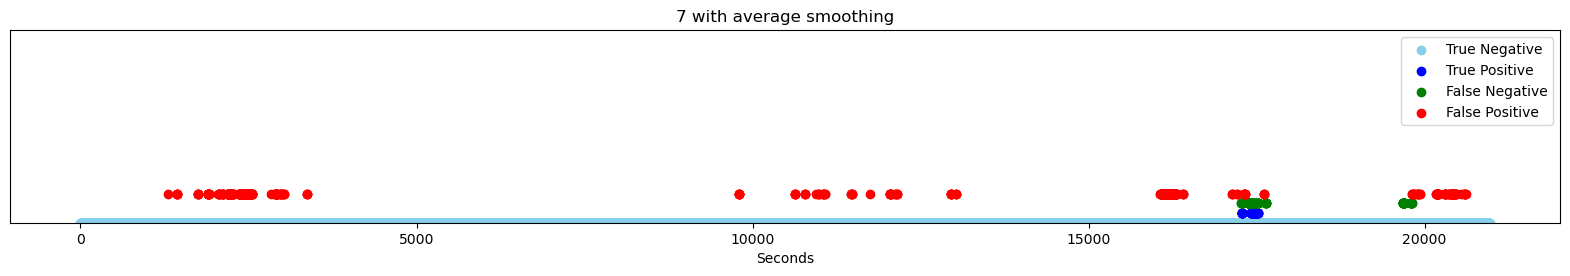

In [12]:
pred = ensemble_predict(models, X_test).flatten() 
print(pred.shape, y_test.shape)
w = 5 # window in seconds
pred = np.convolve(pred, np.ones(w), mode='same') / w >= 0.5

print(pred.shape, y_test.shape)
df = pd.DataFrame(np.stack((y_test, pred)).T, columns=['true', 'pred'])
df.pred = df.pred.astype(int)

def classify(row):
    true, pred = row.true, row.pred
    if true == pred and true == 0:
        return 'True Negative'
    elif true == pred and true == 1:
        return 'True Positive'
    elif true != pred and true == 0:
        return 'False Positive'
    else:
        return 'False Negative'
    
df['type'] = df.apply(lambda x: classify(x), axis=1)
types = df.type.value_counts().sort_index()[::-1]
print(types)

fig, ax = plt.subplots(figsize=(20, 2.5))
i = 0
colors = ['skyblue', 'blue', 'green', 'red']
types_ = ['True Negative', 'True Positive', 'False Negative', 'False Positive']

for j, t in enumerate(types_):
    try:
        ax.scatter(df[df.type==t].index, [i]*types[t], label=t, c=colors[j])
    except KeyError:
        print(f'There is no {t}')
    i += 0.1

ax.legend()
ax.set_ylim(0, 2)
ax.set_xlabel('Seconds')
ax.get_yaxis().set_visible(False)
ax.set_title(f'{label} with average smoothing')